# Axisymmetric Taylor-Couette flow in Dedalus


![Taylor Couette Flow](http://upload.wikimedia.org/wikipedia/commons/3/3d/CouetteTaylorSystem.svg "Taylor Couette Flow")
(image: wikipedia)

Taylor-Couette flow is characterized by three dimensionless numbers:

$\eta = R1/R2$, the ratio of the inner cylidner radius $R_1$ to the outer cylinder radius $R_2$

$\mu = \Omega_2/\Omega_1$, the ratio of the OUTER cylinder rotation rate $\Omega_2$ to the inner rate $\Omega_1$

$\mathrm{Re} = \Omega_1 R_1 \delta/\nu$, the Reynolds numbers, where $\delta = R_2 - R_1$, the gap width between the cylinders


We non dimensionalize the flow in terms of 

$[\mathrm{L}] = \delta = R_2 - R_1$ 

$[\mathrm{V}] = R_1 \Omega_1$ 

$[\mathrm{M}] = \rho \delta^3$

And choose $\delta = 1$, $R_1 \Omega_1 = 1$, and $\rho = 1$.

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import numpy as np
import time
import h5py

import dedalus.public as de 
from dedalus.extras import flow_tools

Here, we set logging to `INFO` level. Currently, by default, the parsing in Dedalus sets its logging output to `DEBUG` in notebooks, which produces more info than we need here.

In [3]:
import logging
root = logging.root
for h in root.handlers:
    h.setLevel("INFO")
    
logger = logging.getLogger(__name__)

## Input parameters

These parameters are taken from Barenghi (1991) J. Comp. Phys. After running, we'll compare it compute the growth rate and compare it to the value $\gamma_{analytic} = 0.430108693$

In [4]:
# input parameters from Barenghi (1991)
eta = 1./1.444 # R1/R2
alpha = 3.13   # vertical wavenumber
Re = 80.       # in units of R1*Omega1*delta/nu
mu = 0.        # Omega2/Omega1

# computed quantitites
omega_in = 1.
omega_out = mu * omega_in
r_in = eta/(1. - eta)
r_out = 1./(1. - eta)
height = 2.*np.pi/alpha 
v_l = 1. # by default, we set v_l to 1.
v_r = omega_out*r_out

## Problem Domain
Every PDE takes place somewhere, so we define a *domain*, which in this case is the $z$ and $r$ directions. Because the $r$ direction has walls, we use a `Chebyshev` basis, but the $z$ direction is periodic, so we use a `Fourier` basis. The `Domain` object combines these.

In [5]:
# bases
r_basis = de.Chebyshev('r', 32, interval=(r_in, r_out), dealias=3/2)
z_basis = de.Fourier('z', 32, interval=(0., height), dealias=3/2)
domain = de.Domain([z_basis, r_basis], grid_dtype=np.float64)

## Equations

We use the `IVP` object, which can parse a set of equations in plain text and combine them into an initial value problem.

Here, we code up the equations for the "primative" variables, $\mathbf{v} = u \mathbf{\hat{r}} + v \mathbf{\hat{\theta}} + w \mathbf{\hat{z}}$ and $p$, along with their first derivatives. 

The equations are the incompressible, axisymmetric Navier-Stokes equations in cylindrical coordinates

The axes will be called $z$ and $r$, and we will expand the non-constant $r^2$ terms, to a cutoff precision of $10^{-8}$. These non-constant coefficients (called "NCC" in Dedalus) are geometric here, but they could be background states in convection, or position dependent diffusion coefficients, or whatever.

We also add the parameters to the object, so we can use their names in the equations below.

In [6]:
TC = de.IVP(domain, 
            variables=['p', 'u', 'v', 'w', 'ur', 'vr', 'wr'],ncc_cutoff=1e-8)
TC.parameters['nu'] = 1./Re
TC.parameters['v_l'] = v_l
TC.parameters['v_r'] = v_r
mu = TC.parameters['v_r']/TC.parameters['v_l'] * eta

The equations are multiplied through by $r^2$, so that there are no $1/r$ terms, which require more coefficients in the expansion

In [7]:
TC.add_equation("r*ur + u + r*dz(w) = 0")
TC.add_equation("r*r*dt(u) - r*r*nu*dr(ur) - r*nu*ur - r*r*nu*dz(dz(u)) + nu*u + r*r*dr(p) = -r*r*u*ur - r*r*w*dz(u) + r*v*v")
TC.add_equation("r*r*dt(v) - r*r*nu*dr(vr) - r*nu*vr - r*r*nu*dz(dz(v)) + nu*v  = -r*r*u*vr - r*r*w*dz(v) - r*u*v")
TC.add_equation("r*dt(w) - r*nu*dr(wr) - nu*wr - r*nu*dz(dz(w)) + r*dz(p) = -r*u*wr - r*w*dz(w)")
TC.add_equation("ur - dr(u) = 0")
TC.add_equation("vr - dr(v) = 0")
TC.add_equation("wr - dr(w) = 0")

## Initial and Boundary Conditions

First we create some aliases to the $r$ and $z$ grids, so we can quickly compute the analytic Couette flow solution for unperturbed, unstable axisymmetric flow.

In [8]:
r = domain.grid(1, scales=domain.dealias)
z = domain.grid(0, scales=domain.dealias)
 
p_analytic = (eta/(1-eta**2))**2 * (-1./(2*r**2*(1-eta)**2) -2*np.log(r) +0.5*r**2 * (1.-eta)**2)
v_analytic = eta/(1-eta**2) * ((1. - mu)/(r*(1-eta)) - r * (1.-eta) * (1 - mu/eta**2)) 

And now we add boundary conditions, simply by typing them in plain text, just like the equations.

In [9]:
# boundary conditions
TC.add_bc("left(u) = 0")
TC.add_bc("left(v) = v_l")
TC.add_bc("left(w) = 0")
TC.add_bc("right(u) = 0", condition="nz != 0")
TC.add_bc("right(v) = v_r")
TC.add_bc("right(w) = 0")
TC.add_bc("integ(p,'r') = 0", condition="nz == 0")

We can now set the parameters of the problem, $\nu$, $v_l$, and $v_r$, and have the code log $\mu$ to the output (which can be `stdout`, a file, or both).

## Timestepping

Dedalus comes with a lot of timesteppers, and makes it very easy to add your favorite one. Here we pick `RK443`, an IMEX Runga-Kutta scheme. We set our maximum timestep `max_dt`, and choose the various stopping parameters.

Finally, we've got our full initial value problem (represented by the `IVP`) object: a timestepper, a domain, and a `ParsedProblem` (or equation set)

In [10]:
dt = max_dt = 1.
omega1 = TC.parameters['v_l']/r_in
period = 2*np.pi/omega1

ts = de.timesteppers.RK443
IVP = TC.build_solver(ts)
IVP.stop_sim_time = 15.*period
IVP.stop_wall_time = np.inf
IVP.stop_iteration = 10000000

INFO:pencil:Building pencil matrix 1/16 (~6%) Elapsed: 0s, Remaining: 0s, Rate: 3.7e+01/s


2016-05-02 12:16:44,321 pencil 0/1 INFO :: Building pencil matrix 1/16 (~6%) Elapsed: 0s, Remaining: 0s, Rate: 3.7e+01/s


INFO:pencil:Building pencil matrix 2/16 (~12%) Elapsed: 0s, Remaining: 0s, Rate: 3.6e+01/s


2016-05-02 12:16:44,349 pencil 0/1 INFO :: Building pencil matrix 2/16 (~12%) Elapsed: 0s, Remaining: 0s, Rate: 3.6e+01/s


INFO:pencil:Building pencil matrix 4/16 (~25%) Elapsed: 0s, Remaining: 0s, Rate: 3.6e+01/s


2016-05-02 12:16:44,404 pencil 0/1 INFO :: Building pencil matrix 4/16 (~25%) Elapsed: 0s, Remaining: 0s, Rate: 3.6e+01/s


INFO:pencil:Building pencil matrix 6/16 (~38%) Elapsed: 0s, Remaining: 0s, Rate: 3.7e+01/s


2016-05-02 12:16:44,457 pencil 0/1 INFO :: Building pencil matrix 6/16 (~38%) Elapsed: 0s, Remaining: 0s, Rate: 3.7e+01/s


INFO:pencil:Building pencil matrix 8/16 (~50%) Elapsed: 0s, Remaining: 0s, Rate: 3.6e+01/s


2016-05-02 12:16:44,516 pencil 0/1 INFO :: Building pencil matrix 8/16 (~50%) Elapsed: 0s, Remaining: 0s, Rate: 3.6e+01/s


INFO:pencil:Building pencil matrix 10/16 (~62%) Elapsed: 0s, Remaining: 0s, Rate: 3.6e+01/s


2016-05-02 12:16:44,570 pencil 0/1 INFO :: Building pencil matrix 10/16 (~62%) Elapsed: 0s, Remaining: 0s, Rate: 3.6e+01/s


INFO:pencil:Building pencil matrix 12/16 (~75%) Elapsed: 0s, Remaining: 0s, Rate: 3.7e+01/s


2016-05-02 12:16:44,623 pencil 0/1 INFO :: Building pencil matrix 12/16 (~75%) Elapsed: 0s, Remaining: 0s, Rate: 3.7e+01/s


INFO:pencil:Building pencil matrix 14/16 (~88%) Elapsed: 0s, Remaining: 0s, Rate: 3.7e+01/s


2016-05-02 12:16:44,676 pencil 0/1 INFO :: Building pencil matrix 14/16 (~88%) Elapsed: 0s, Remaining: 0s, Rate: 3.7e+01/s


INFO:pencil:Building pencil matrix 16/16 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 3.7e+01/s


2016-05-02 12:16:44,729 pencil 0/1 INFO :: Building pencil matrix 16/16 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 3.7e+01/s


We initialize the state vector, given by `IVP.state`. To make life a little easier, we set some aliases first:

In [11]:
p = IVP.state['p']
u = IVP.state['u']
v = IVP.state['v']
w = IVP.state['w']
ur = IVP.state['ur']
vr = IVP.state['vr']
wr = IVP.state['wr']

Next, we create a new field, $\phi$, defined on the `domain`, which we'll use below to compute incompressible, random velocity perturbations.

In [12]:
phi = domain.new_field(name='phi')

Here, we set all these to their dealiased domains. Dedalus allows you to set the "scale" of your data: this allows you to interpolate your data to a grid of any size at spectral accuracy. Of course, this isn't CSI: Fluid Dynamics, so you won't get any more detail than your highest spectral coefficient.

In [13]:
for f in [phi,p,u,v,w,ur,vr,wr]:
    f.set_scales(domain.dealias, keep_data=False)

Now we set the state vector with our previously computed analytic solution, compute the first derivatives (to make our system first order)

In [14]:
v['g'] = v_analytic
#p['g'] = p_analytic

v.differentiate('r',out=vr)

<Field 140545185430608>

And finally, we set some small, incompressible perturbations to the velocity field so we can kick off our linear instability.

First, we initialize $\phi$ (which we created above) to Gaussian noise and then mask it to only appear in the center of the domain, so we don't violate the boundary conditions. We then take its curl to get the velocity perturbations.

Unfortunately, Gaussian noise on the grid is generally a bad idea: zone-to-zone variations (that is, the highest frequency components) will be amplified arbitrarily by any differentiation. So, let's filter out those high frequency components using this handy little function:

In [15]:
def filter_field(field,frac=0.5):
    dom = field.domain
    local_slice = dom.dist.coeff_layout.slices(scales=dom.dealias)
    coeff = []
    for i in range(dom.dim)[::-1]:
        coeff.append(np.linspace(0,1,dom.global_coeff_shape[i],endpoint=False))
    cc = np.meshgrid(*coeff)
    
    field_filter = np.zeros(dom.local_coeff_shape,dtype='bool')
    for i in range(dom.dim):
        field_filter = field_filter | (cc[i][local_slice] > frac)
    field['c'][field_filter] = 0j

This is not the best filter: it assumes that cutting off above a certain Chebyshev mode $n$ and Fourier mode $n$ will be OK, though this may produce anisotropies in the data (I haven't checked). If you're worrying about the anisotropy of the initial noise of your ICs, you can always replace this filter with something better.

In [16]:
# incompressible perturbation, arbitrary vorticity
# u = -dz(phi)
# w = dr(phi) + phi/r

phi['g'] = 1e-3* np.random.randn(*v['g'].shape)*np.sin(np.pi*(r - r_in))
filter_field(phi)
phi.differentiate('z',out=u)
u['g'] *= -1
phi.differentiate('r',out=w)
w['g'] += phi['g']/r

u.differentiate('r',out=ur)
w.differentiate('r',out=wr)

<Field 140545185431168>

Now we check that incompressibility is indeed satisfied, first by computing $\nabla \cdot u$,

In [17]:
divu0 = domain.new_field(name='divu0')
u.differentiate('r',out=divu0)
divu0['g'] += u['g']/r + w.differentiate('z')['g']

and then by plotting it to make sure it's nowhere greater than $\sim 10^{-15}$

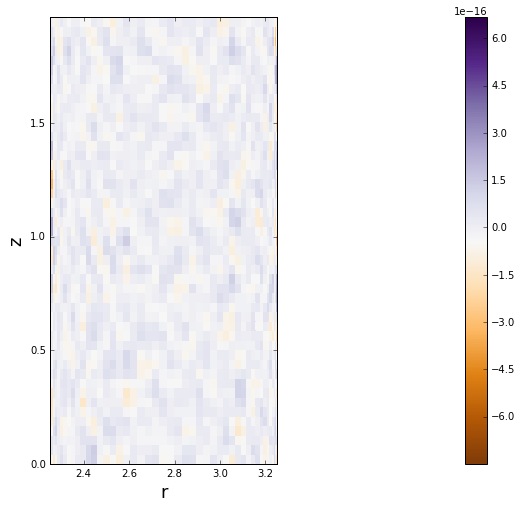

In [18]:
figsize(12,8)
pcolormesh((r[0]*ones_like(z)).T,(z*ones_like(r)).T,divu0['g'].T,cmap='PuOr')
colorbar()
axis('image')
xlabel('r', fontsize=18)
ylabel('z', fontsize=18)

## Time step size and the CFL condition

Here, we use the nice CFL calculator provided by the `flow_tools` package in the `extras` module.

In [19]:
CFL = flow_tools.CFL(IVP, initial_dt=1e-3, cadence=5, safety=0.3,
                     max_change=1.5, min_change=0.5)
CFL.add_velocities(('u', 'w'))

## Analysis

Dedalus has a very powerful inline analysis system, and here we set up a few.

In [20]:
# Integrated energy every 10 iterations
analysis1 = IVP.evaluator.add_file_handler("scalar_data", iter=10)
analysis1.add_task("integ(0.5 * (u*u + v*v + w*w))", name="total kinetic energy")
analysis1.add_task("integ(0.5 * (u*u + w*w))", name="meridional kinetic energy")
analysis1.add_task("integ((u*u)**0.5)", name='u_rms')
analysis1.add_task("integ((w*w)**0.5)", name='w_rms')

# Snapshots every half an inner rotation period
analysis2 = IVP.evaluator.add_file_handler('snapshots',sim_dt=0.5*period, max_size=2**30)
analysis2.add_system(IVP.state, layout='g')

# radial profiles every 100 timestpes
analysis3 = IVP.evaluator.add_file_handler("radial_profiles", iter=100)
analysis3.add_task("integ(r*v, 'z')", name='Angular Momentum')

## The Main Loop
And here we actually run the simulation!

In [21]:
dt = CFL.compute_dt()
# Main loop
start_time = time.time()

while IVP.ok:
    IVP.step(dt)
    if IVP.iteration % 10 == 0:
        logger.info('Iteration: %i, Time: %e, dt: %e' %(IVP.iteration, IVP.sim_time, dt))
    dt = CFL.compute_dt()


end_time = time.time()

# Print statistics
logger.info('Total time: %f' %(end_time-start_time))
logger.info('Iterations: %i' %IVP.iteration)
logger.info('Average timestep: %f' %(IVP.sim_time/IVP.iteration))

INFO:__main__:Iteration: 10, Time: 1.750000e-02, dt: 2.250000e-03


2016-05-02 12:16:45,983 __main__ 0/1 INFO :: Iteration: 10, Time: 1.750000e-02, dt: 2.250000e-03


INFO:__main__:Iteration: 20, Time: 5.687500e-02, dt: 5.062500e-03


2016-05-02 12:16:46,836 __main__ 0/1 INFO :: Iteration: 20, Time: 5.687500e-02, dt: 5.062500e-03


INFO:__main__:Iteration: 30, Time: 1.454687e-01, dt: 1.139063e-02


2016-05-02 12:16:47,690 __main__ 0/1 INFO :: Iteration: 30, Time: 1.454687e-01, dt: 1.139063e-02


INFO:__main__:Iteration: 40, Time: 3.448047e-01, dt: 2.562891e-02


2016-05-02 12:16:48,553 __main__ 0/1 INFO :: Iteration: 40, Time: 3.448047e-01, dt: 2.562891e-02


INFO:__main__:Iteration: 50, Time: 7.933105e-01, dt: 5.766504e-02


2016-05-02 12:16:49,356 __main__ 0/1 INFO :: Iteration: 50, Time: 7.933105e-01, dt: 5.766504e-02


INFO:__main__:Iteration: 60, Time: 1.802449e+00, dt: 1.297463e-01


2016-05-02 12:16:50,150 __main__ 0/1 INFO :: Iteration: 60, Time: 1.802449e+00, dt: 1.297463e-01


INFO:__main__:Iteration: 70, Time: 4.073010e+00, dt: 2.919293e-01


2016-05-02 12:16:50,941 __main__ 0/1 INFO :: Iteration: 70, Time: 4.073010e+00, dt: 2.919293e-01


INFO:__main__:Iteration: 80, Time: 9.181772e+00, dt: 6.568408e-01


2016-05-02 12:16:51,731 __main__ 0/1 INFO :: Iteration: 80, Time: 9.181772e+00, dt: 6.568408e-01


INFO:__main__:Iteration: 90, Time: 2.067649e+01, dt: 1.477892e+00


2016-05-02 12:16:52,508 __main__ 0/1 INFO :: Iteration: 90, Time: 2.067649e+01, dt: 1.477892e+00


INFO:__main__:Iteration: 100, Time: 4.653959e+01, dt: 3.325257e+00


2016-05-02 12:16:53,320 __main__ 0/1 INFO :: Iteration: 100, Time: 4.653959e+01, dt: 3.325257e+00


INFO:__main__:Iteration: 110, Time: 1.047316e+02, dt: 7.481828e+00


2016-05-02 12:16:54,142 __main__ 0/1 INFO :: Iteration: 110, Time: 1.047316e+02, dt: 7.481828e+00


INFO:solvers:Simulation stop time reached.


2016-05-02 12:16:54,907 solvers 0/1 INFO :: Simulation stop time reached.


INFO:__main__:Total time: 9.767014


2016-05-02 12:16:54,908 __main__ 0/1 INFO :: Total time: 9.767014


INFO:__main__:Iterations: 119


2016-05-02 12:16:54,909 __main__ 0/1 INFO :: Iterations: 119


INFO:__main__:Average timestep: 1.838903


2016-05-02 12:16:54,910 __main__ 0/1 INFO :: Average timestep: 1.838903


## Analysis

First, let's look at our last time snapshot, plotting the background $v \mathbf{\hat{\theta}}$ velocity with arrows representing the meridional flow:

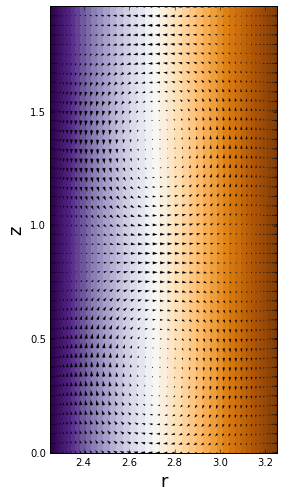

In [22]:
figsize(12,8)
pcolormesh((r[0]*ones_like(z)).T,(z*ones_like(r)).T,v['g'].T,cmap='PuOr')
quiver((r[0]*ones_like(z)).T,(z*ones_like(r)).T,u['g'].T,w['g'].T,width=0.005)
axis('image')
xlabel('r', fontsize=18)
ylabel('z', fontsize=18)

But we really want some quantitative comparison with the growth rate $\gamma_{analytic}$ from Barenghi (1991). First we construct a small helper function to read our timeseries data, and then we load it out of the self-documented HDF5 file

In [23]:
def get_timeseries(data, field):
    data_1d = []
    time = data['scales/sim_time'][:]
    data_out = data['tasks/%s'%field][:,0,0]
    return time, data_out

In [24]:
data = h5py.File("scalar_data/scalar_data_s1/scalar_data_s1_p0.h5", "r")
t, ke = get_timeseries(data, 'total kinetic energy')
t, kem = get_timeseries(data, 'meridional kinetic energy')
t, urms = get_timeseries(data, 'u_rms')
t, wrms = get_timeseries(data, 'w_rms')

In order to compare to Barenghi (1991), we scale our results by the Reynolds number, because we have non-dimensionalized slightly differently than he did. 

In [25]:
t_window = (t/period > 2) & (t/period < 14)

gamma_w, log_w0 = np.polyfit(t[t_window], np.log(wrms[t_window]),1)

gamma_w_scaled = gamma_w*Re
gamma_barenghi = 0.430108693
rel_error_barenghi = (gamma_barenghi - gamma_w_scaled)/gamma_barenghi

print("gamma_w = %10.8f" % gamma_w_scaled)
print("relative error = %10.8e" % rel_error_barenghi)

gamma_w = 0.37198093
relative error = 1.35146694e-01


This looks like a rather high error (order 10% or so), but we know from Barenghi (1991) that the error is dominated by the timestep. Here, we've used a very loose timestep, but if you fix dt (rather than using the CFL calculator), you can get much lower errors at the cost of a longer run.

Finally, we plot the RMS $w$ velocity, and compare it with the fitted exponential solution

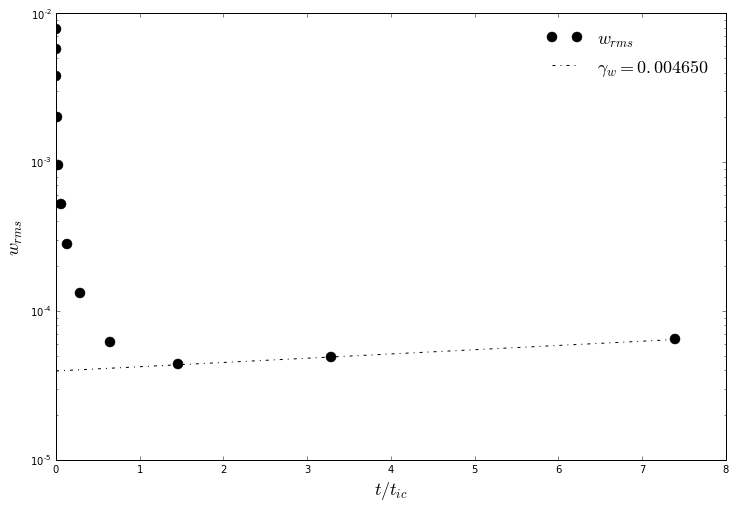

In [26]:
fig = figure()
ax = fig.add_subplot(111)
ax.semilogy(t/period, wrms, 'ko', label=r'$w_{rms}$',ms=10)
ax.semilogy(t/period, np.exp(log_w0)*np.exp(gamma_w*t), 'k-.', label='$\gamma_w = %f$' % gamma_w)
ax.legend(loc='upper right',fontsize=18).draw_frame(False)
ax.set_xlabel(r"$t/t_{ic}$",fontsize=18)
ax.set_ylabel(r"$w_{rms}$",fontsize=18)

fig.savefig('growth_rates.png')